<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/keras_dis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/disseration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/disseration


Import modules

In [2]:
%tensorflow_version 2.x
!pip install pynndescent
!pip install tbb

import numpy as np
import string
import os
from bisect import bisect_left
import pickle

import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.models import load_model
from keras.losses import MSE
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pynndescent
from urllib.request import urlretrieve

Mnist dataset

In [3]:
num_classes = 10
input_shape = (28, 28, 1)

# import mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale to [0, 1] size
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# keep raw labels in separate array
y_test_raw = y_test[750:10000]
y_train_raw = y_train
y_cal_raw = y_test[0:750]

# convert labels to one hot enconding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split test set into calibration set
x_cal = x_test[0:750] 
y_cal = y_test[0:750]
x_test = x_test[750:10000]
y_test = y_test[750:10000]

Initialize CNN model

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding='same', activation='relu', input_shape=x_train.shape[1:]),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding='valid', activation='relu'),
        layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

adam_opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

neighbours_layers_indexes = [0,1,2]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         409728    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 710,218
Trainable params: 710,218
Non-trai

In [5]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(64, kernel_size=(8, 8), strides=(1,1), padding="same", activation="relu", input_shape=x_train.shape[1:]),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(128, kernel_size=(6, 6), strides=(1,1), padding="valid", activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding="valid", activation="relu"),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(10, activation=tf.nn.softmax),
#     ]
# )

# batch_size = 500
# epochs = 8

# adam_opt = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

# model.summary()

Train model


In [6]:
# try loading model from files
try:
  model = load_model('deepKNN_model1.h5')
  print("loaded model from disc")

# otherwise train from scratch
except OSError:
  print("failed to load model from disc")
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
  # model.save('deepKNN_model_new.h5')  # creates a HDF5 file
  print("saved model successfully")

loaded model from disc


Evaluate model

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02895638532936573
Test accuracy: 0.9907026886940002


Generate Adversarial Examples

In [8]:
def generate_image_adversary(model, image, label, eps):

  # Make images shape (1, 28, 28, 1)
  image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)

  # record our gradients
  with tf.GradientTape() as tape:

    # start tracing image by the Tape
    tape.watch(image)

    #compute prediction
    pred = model(image)

    # compute loss
    loss = MSE(label, pred)

    # calculate the gradient of loss function 
    grad = tape.gradient(loss, image)

    # compute the sign of the gradient
    sign = tf.sign(grad)

    # create perturbation
    perturbation = sign * eps

    # apply perturbation to image
    adversary = (image + perturbation).numpy()

    # Make images shape (28, 28, 1)
    adversary = adversary.reshape(28, 28, 1)
    
    return adversary

In [9]:
def load_adversarial():
  epsilons.insert(0, 0.0)
  adversaries = {}
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    path = 'adv_datasets/adversaries' + eps_str + '.npy'
    adversaries[eps] = np.load(path)
  return adversaries

def save_adversarial(adversaries, end_str):
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    filename = 'adv_datasets/adversaries' + eps_str + end_str + '.npy'
    np.save(filename, adversaries[eps])

In [10]:
# pixel-wise perturbation amount 
epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
# epsilons = [0.025, 0.05, 0.075]

# try loading adversarial examples from files
try:
  fgsm_adversarials = load_adversarial()
  print('loaded adversarial datasets from disc')

# otherwise generate adversarial examples
except FileNotFoundError:
  print('failed to load adversarial datasets from disc')
  fgsm_adversarials = {}

  for eps in epsilons:
    adv = []
    for i in range(x_test.shape[0]):
      adv.append(generate_image_adversary(model, x_test[i], y_test[i], eps))
    fgsm_adversarials[eps] = np.array(adv)

  # add raw test set as 0.0 epsilon
  epsilons.insert(0, 0.0)
  fgsm_adversarials[0.0] = x_test

  # save_adversarial(fgsm_adversarials, '')
  print('saved adversarial dataset successfully')

loaded adversarial datasets from disc


Test model on adversarial attacks

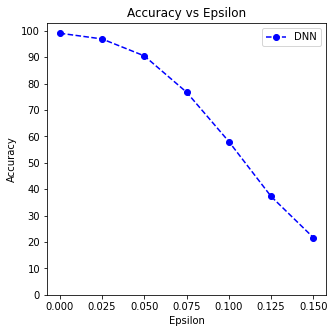

In [11]:
def plot_accuracy_vs_epsilon():
  accuracies_plot = []
  for eps in epsilons:
    adversary_score = model.evaluate(fgsm_adversarials[eps], y_test, verbose=0)
    accuracies_plot.append(adversary_score[1] * 100)

  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies_plot, linestyle='--', marker='o', color='b', label = 'DNN')

  plt.yticks(np.arange(0, 101, step=10))
  plt.xticks(np.arange(0, 0.16, step=0.025))
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epsilon")
  plt.legend()
  
plot_accuracy_vs_epsilon()
plt.show()

Plot some adversarial examples

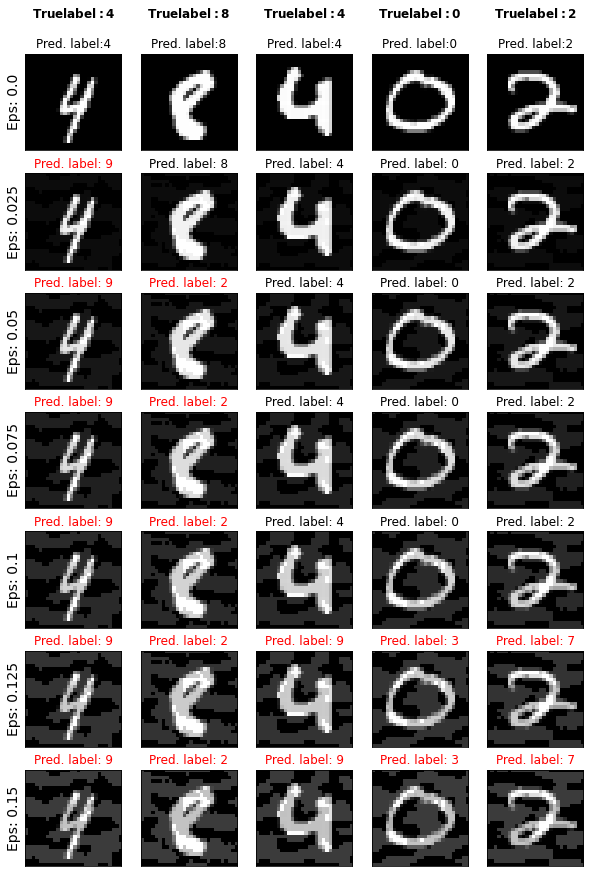

In [12]:
counter = 0
plt.figure(figsize=(10,15))

for eps in epsilons:
  adv_img = fgsm_adversarials[eps][10:15]
  true_label = y_test[10:15]

  adv_results = model.predict(fgsm_adversarials[eps][10:15])
  predicted_labels = []
  for result in adv_results:
    predicted_labels.append(np.argmax(result))

  for i in range(5):
      counter += 1
      plt.subplot(len(epsilons), 5, counter)
      plt.xticks([], [])
      plt.yticks([], [])

      if i == 0:
        plt.ylabel('Eps: '+ str(eps), fontsize=14)

      label = np.argmax(true_label[i])
      if predicted_labels[i] != label:
        incorrect_label = plt.title('Pred. label: ' + str(predicted_labels[i]))
        plt.setp(incorrect_label, color='r')
      else:
        if eps == 0.0:
          plt.title(r"$\bf{" + 'True label:' + str(label) + "}$" + '\n\nPred. label:' + str(predicted_labels[i]))
        else:
          plt.title('Pred. label: ' + str(predicted_labels[i]))

      plt.imshow(np.squeeze(adv_img[i]), cmap="gray")
plt.show()

KNN for patterns

In [13]:
# # reformat training data
# x_train_knn = np.squeeze(x_train, -1)
# x_train_knn = x_train_knn.reshape((60000, 784))

# # index training data
# index = pynndescent.NNDescent(x_train_knn)

# # prepare for faster query
# index.prepare()

# reformat test data
# x_test_knn = np.squeeze(x_test, -1)
# x_test_knn = x_test_knn.reshape((7500, 784))

# find neighbors for test data
# neighbors = index.query(x_test_knn)

# # create gold standard from KDTree ###
# from sklearn.neighbors import KDTree
# tree_index = KDTree(x_train)

# tree_neighbors = tree_index.query(x_test, k=10)

# def accuracy_per_query_point(approx_neighbors, true_neighbors):
#     approx_indices = approx_neighbors[0]
#     result = np.zeros(approx_indices.shape[0])
#     for i in range(approx_indices.shape[0]):
#         n_correct = np.intersect1d(approx_indices[i], true_neighbors[i]).shape[0]
#         result[i] = n_correct / true_neighbors.shape[1]
#     return result

# tree_N = np.load('test_true_neighbors.npy')

# accuracy_stats = accuracy_per_query_point(neighbors, tree_N)
# sns.set(rc={"figure.figsize":(10,6)})

# sns.distplot(accuracy_stats, kde=False)
# plt.title("Distribution of accuracy per query point")
# plt.xlabel("Accuracy")
# print(f"Average accuracy of {np.mean(accuracy_stats)}")

Functions for saving and loading precalulated neighbours

In [14]:
def save_pickle(save_object, filename):
  with open(filename, 'wb') as f:
    pickle.dump(save_object, f)

def load_pickle(filename):
  with open(filename, 'rb') as f:
    loaded_object = pickle.load(f)
    return loaded_object

Function getting activations on each layer

In [15]:
def get_activations(model, dataset):
    reshaped_output_layer = []
    for i in neighbours_layers_indexes: # 0,1,2-convolutions layer, 5-dense layer
        layer = model.layers[i]
        l_op = K.function([model.layers[0].input], [layer.output])([dataset])[0]
        if i != 5:
          reshaped_output_layer.append(l_op.reshape(l_op.shape[0], l_op.shape[1]*l_op.shape[2]*l_op.shape[3]))
        else: 
          reshaped_output_layer.append(l_op)
    
    for layer in reshaped_output_layer:
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)

    return(reshaped_output_layer)

Index trainingset knn

In [16]:
def index_layer(layer, activations_train):
  layer_act = activations_train[layer]
  index_act = pynndescent.NNDescent(layer_act) # index training data
  index_act.prepare() # prepare for faster query
  return index_act

try: 
  index_act = load_pickle('neighbours_index_1.pkl')
  print('loaded neighbours index from disc')
except FileNotFoundError:
  print('failed to load neighbours index from disc')
  index_act = {}
  activations_train = get_activations(model, x_train)
  for layer in range (len(neighbours_layers_indexes)):
    index_act[layer] = index_layer(layer, activations_train)

loaded neighbours index from disc


Find Neigbours

In [17]:
k_neighbours = 75
def find_neighbours(activations, index, layer, knn_eps):
  act = activations[layer]
  neighbors = index.query(act, k=k_neighbours, epsilon=knn_eps)
  return neighbors[0]

def correct_neighbours_count(neihgbours):
  correct_neighbours = [0] * (k_neighbours + 1)
  for i in range(0, neihgbours.shape[0]):
    correct = np.sum(y_train_raw[neihgbours[i]] == y_test_raw[i])
    correct_neighbours[correct] += 1
  return correct_neighbours

def compare_neigbours(neighbours, layer, eps):
  plt.figure(figsize=(15,5))
  x_ax = np.arange(len(neighbours[layer][0.0]))
  plt.bar(x_ax-0.2, neighbours[layer][0.0], 0.4, label = 'Epsilon: 0.0')
  plt.bar(x_ax+0.2, neighbours[layer][eps], 0.4, label = 'Epsilon: ' + str(eps))

  plt.xlabel("Neigbours")
  plt.ylabel("Number of correct neigbours")
  plt.title("Number of correct neigbours on layer number: " + str(layer+1))
  plt.legend()

  plt.xticks(x_ax);
  plt.show() 

Get activations on each layer


In [18]:
activations = {}
for eps in epsilons:
  activations[eps] = get_activations(model, fgsm_adversarials[eps])

Find neigbours on each layer

In [19]:
try:
  neighbors = load_pickle('neighbours_1.pkl')
  print('loaded neighbours from disc')
except FileNotFoundError:
  print('failed to load neighbours from disc')
  neighbors = {}
  for layer in range (len(neighbours_layers_indexes)):
    neighbors[layer] = {}
    for eps in epsilons:
      neighbors[layer][eps] = find_neighbours(activations[eps], index_act[layer], layer, 0.1)

loaded neighbours from disc


In [20]:
correct_neighbours = {}
for layer in range (len(neighbours_layers_indexes)):
  correct_neighbours[layer] = {}
  for eps in epsilons:
    correct_neighbours[layer][eps] = correct_neighbours_count(neighbors[layer][eps])

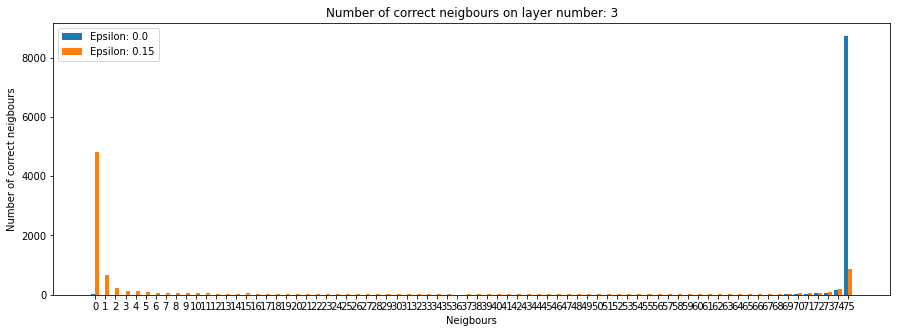

In [21]:
compare_neigbours(correct_neighbours, 2, 0.15)

Calibration set

In [22]:
activations_calib = get_activations(model, x_cal)
neigbours_calib = {}
for layer in range (len(neighbours_layers_indexes)):
  neigbours_calib[layer] = find_neighbours(activations_calib, index_act[layer], layer, 0.1)

In [23]:
# Returns how many neighbours does not match real label
def nonconformity_calibration(neihgbours_arr):
  nonconformity = []
  for i in range(0, neihgbours_arr.shape[0]):
    incorrect = np.sum(y_train_raw[neihgbours_arr[i]] != y_cal_raw[i])
    nonconformity.append(incorrect)

  return np.array(nonconformity)

In [24]:
# nonconformity of calib
nonconformity_calib = np.zeros(neigbours_calib[0].shape[0])
for layer in range (len(neighbours_layers_indexes)):
  nonconformity_calib += nonconformity_calibration(neigbours_calib[layer])

# sort
nonconformity_calib =  np.sort(nonconformity_calib)
# trim zeros
nonconformity_calib = np.trim_zeros(nonconformity_calib, trim='f')

Calculate p-values, credibility and predicted labels

In [25]:
# calculate_nonconformity for each class based on calibration
def calculate_nonconformity(eps):
  nonconformity_for_class = np.full((x_test.shape[0], num_classes), k_neighbours * len(neighbours_layers_indexes), dtype=np.float32)
  for i in range(0, x_test.shape[0]):
    for layer in range(len(neighbours_layers_indexes)):
      for neigh in neighbors[layer][eps][i]:
        nonconformity_for_class[i][y_train_raw[neigh]] -= 1

  return nonconformity_for_class

def calculate_p_values(nonconformity_for_class, nonconformity):
  p_values = np.empty((x_test.shape[0], num_classes),  dtype=np.float32)
  for i in range(0, x_test.shape[0]):
    for j in range(0, num_classes):
      insert_index = bisect_left(nonconformity, nonconformity_for_class[i][j])
      p_values[i][j] = (nonconformity.shape[0] - insert_index) / nonconformity.shape[0]
  return p_values

def predict_labels(eps):
  knn_predicted_labels = []
  for i in range(0, x_test.shape[0]):
    knn_predicted_labels.append(np.argmin(nonconformity_for_class[eps][i]))
  return np.array(knn_predicted_labels)

In [26]:
nonconformity_for_class = {}
p_values = {}
knn_predicted_labels = {}
for eps in epsilons:
  nonconformity_for_class[eps] = calculate_nonconformity(eps)
  p_values[eps] = calculate_p_values(nonconformity_for_class[eps], nonconformity_calib)
  knn_predicted_labels[eps] = predict_labels(eps)

Plot performance in respect to credibility

In [27]:
def calculate_performance_per_cred(confidence, predicted_labels):
  credibility = np.max(confidence, axis=1)
  distribution = np.zeros(10)
  correct_labels = np.zeros(10)

  for i in range(credibility.shape[0]):
    bin = credibility[i] // 0.1 / 10
    bin_index = int(bin*10)
    distribution[bin_index] += 1
    if (predicted_labels[i] == y_test_raw[i]):
      correct_labels[bin_index] += 1

  for i in range(correct_labels.shape[0]):
    if correct_labels[i] != 0 and distribution[i] != 0:
      correct_labels[i] /=  distribution[i]

  return distribution, correct_labels 

def plot_reliability(model_type, eps):

    if model_type == 'DkNN':
      confidence = p_values[eps]
      predicted_labels = knn_predicted_labels[eps]
    elif model_type == 'Softmax':
      softmax_probabilities = model.predict(fgsm_adversarials[eps])
      softmax_classes = softmax_probabilities.argmax(axis=-1)
      confidence = softmax_probabilities
      predicted_labels = softmax_classes

    bars_begin = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    bars_end = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bars_center = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

    num_points, reliability_diag = calculate_performance_per_cred(confidence, predicted_labels)

    fig, ax1 = plt.subplots()
    ax1.bar(bars_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()

    ax2.plot(bars_center, num_points, color='r', linestyle='-', linewidth=6.0)

    plt.title("Reliability Diagram: " + model_type + ', eps: ' + str(eps))
    ax2.set_ylabel('Number of points in dataset', color='r')
    ax1.set_xlabel('Prediction Credibility')
    ax1.set_ylabel('Prediction Accuracy')
    ax2.tick_params(colors='r')
    plt.show()

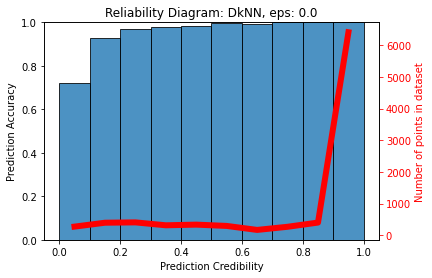

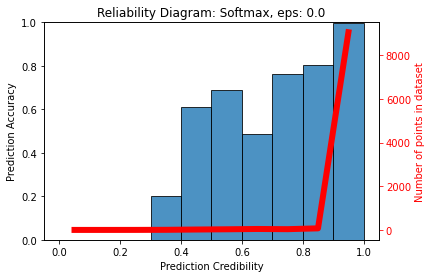

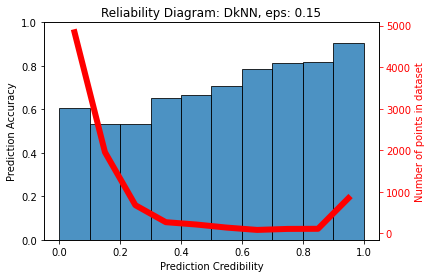

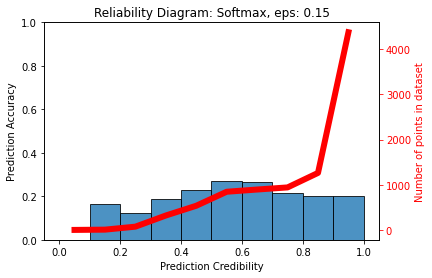

In [28]:
plot_reliability('DkNN', eps = 0.0)
plot_reliability('Softmax', eps = 0.0)
plot_reliability('DkNN', eps = 0.15)
plot_reliability('Softmax', eps = 0.15)

Accuracy of DkNN vs DNN

In [29]:
def test_model_accuracy(labels1, labels2):
  correct_labels = np.sum(labels1 == labels2)
  return correct_labels / labels1.shape[0] * 100

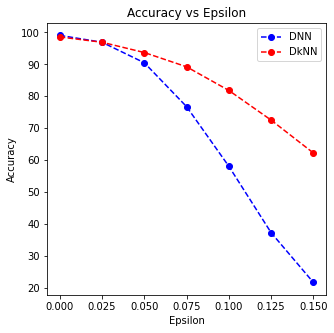

In [30]:
accuracies_plot_knn = []
for eps in epsilons:
  model_accuracy = test_model_accuracy(knn_predicted_labels[eps], y_test_raw)
  accuracies_plot_knn.append(model_accuracy)

plot_accuracy_vs_epsilon()
plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='o', color='r', label = 'DkNN')
plt.legend()
plt.show()

Adversarial Training

In [31]:
adv_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding="same", activation="relu", input_shape=x_train.shape[1:]),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding="valid", activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding="valid", activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

adam_opt = keras.optimizers.Adam(learning_rate=0.001)
adv_model.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

adv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        4160      
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 128)         295040    
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 128)         409728    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 710,218
Trainable params: 710,218
Non-tr

In [32]:
try:
  advarsarial_training_arr = np.load('adversarial_training.npy')
  print('loaded training adversarial')
except FileNotFoundError:
  advarsarial_training = []
  for i in range(x_train.shape[0]):
    advarsarial_training.append(generate_image_adversary(model, x_train[i], y_train[i], 0.1))
  advarsarial_training_arr = np.array(advarsarial_training)

loaded training adversarial


In [33]:
amount = 10000
x_train_adv = np.append(x_train, advarsarial_training_arr[0:amount], axis=0)
y_train_adv = np.append(y_train,y_train[0:amount],axis=0)

In [34]:
adv_model.fit(x_train_adv, y_train_adv, batch_size=batch_size, epochs=epochs+4, validation_split=0.1)

Epoch 1/12
126/126 [==============================] - 3s 13ms/step - loss: 0.4214 - accuracy: 0.8720 - val_loss: 0.5289 - val_accuracy: 0.8291
Epoch 2/12
126/126 [==============================] - 1s 12ms/step - loss: 0.1361 - accuracy: 0.9606 - val_loss: 0.3588 - val_accuracy: 0.8843
Epoch 3/12
126/126 [==============================] - 1s 12ms/step - loss: 0.0892 - accuracy: 0.9742 - val_loss: 0.2313 - val_accuracy: 0.9217
Epoch 4/12
126/126 [==============================] - 1s 12ms/step - loss: 0.0669 - accuracy: 0.9795 - val_loss: 0.1871 - val_accuracy: 0.9357
Epoch 5/12
126/126 [==============================] - 1s 12ms/step - loss: 0.0527 - accuracy: 0.9848 - val_loss: 0.1325 - val_accuracy: 0.9544
Epoch 6/12
126/126 [==============================] - 1s 12ms/step - loss: 0.0417 - accuracy: 0.9871 - val_loss: 0.1085 - val_accuracy: 0.9621
Epoch 7/12
126/126 [==============================] - 1s 12ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.0919 - val_accuracy: 0.9680

In [35]:
score1 = model.evaluate(fgsm_adversarials[0.1], y_test, verbose=0)
score1

[1.5432378053665161, 0.5804324150085449]

In [36]:
score2 = adv_model.evaluate(fgsm_adversarials[0.0], y_test, verbose=0)
score2

[0.028841763734817505, 0.9914594888687134]

In [37]:
score2 = adv_model.evaluate(fgsm_adversarials[0.1], y_test, verbose=0)
score2

[0.16915170848369598, 0.9558919072151184]